In [1]:
# Necessary imports - done
# -------------------------

import os
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import copy
import cv2
from os import listdir
from os.path import isfile, join
import h5py
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import math
import sys
from tqdm import tqdm

import torch
from torch.autograd import Variable
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim

from __future__ import print_function
import scipy
from scipy.ndimage import filters
from scipy import misc
from io import BytesIO


%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp


/Users/venkateshmadhava/Documents/pmate2/pmate2_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: JOBLIB_TEMP_FOLDER=/tmp


# 1. Code

### 1.1 helper functions

In [41]:
# cosine similarity function to find similarity distance between two words
# ------------------------------------------------------------------------

def cosine_similarity_single(u, v):
    
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        formula -- cos thetha = dot_product_of(u,v)/l2_norm(u)*l2_norm(v)
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    
    # Compute the dot product between u and v (≈1 line)
    # -------------------------------------------------
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.sum(np.square(u)))
    norm_v = np.sqrt(np.sum(np.square(v)))
    cosine_similarity_out = dot/(norm_u*norm_v)
    
    # final return
    # -----------
    return cosine_similarity_out

In [42]:
def cosine_similarity_multi(a,b):
    
    '''
    
    1. a,b are of shape (m,no_latent)
    2. output is of shape (m,1)
    
    '''
    
    # 1. direct steps
    # ---------------
    dot_prod = np.sum(a*b, axis = 1)
    norm_a = np.sqrt(np.sum(np.square(a),axis = 1))
    norm_b = np.sqrt(np.sum(np.square(b),axis = 1))
    out = dot_prod/(norm_a*norm_b)
    
    
    # final return
    # -------------
    return out.reshape(out.shape[0],1)

In [43]:
# GENERIC function to calculate conv outsize
# -------------------------------------------- 
def outsize_conv(n_H,n_W,f,s,pad):
    
    h = ((n_H - f + (2*pad))/s) + 1
    w = ((n_W - f + (2*pad))/s) + 1
    return h,w
    
    
# GENERIC function to calculate upconv outsize
# --------------------------------------------    
def outsize_upconv(h,w,f,s,p):
    hout = (h-1)*s - 2*p + f
    wout = (w-1)*s - 2*p + f
    return hout, wout



# GENERIC - initialises weights for a NN
# --------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
        
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()

In [44]:
# simple function to read a single image
# --------------------------------------
def create_dataset_from_folder_all(infolder,resize,n_h,n_w):
    
    # 0. global initialisations
    # -------------------------
    global resize_flag
    resize_flag = resize
    
    global gb_in_folder
    gb_in_folder = infolder

    global counter
    counter = 0
    
    global new_h
    new_h = n_h
    
    global new_w
    new_w = n_w

    global image_list
    image_list = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f]
    
    global x_images_dataset
    x_images_dataset = np.zeros((len(image_list),new_h,new_w,3), dtype='uint8')
    
    # 1.1 sanity assertion
    # -------------------
    assert len(image_list) > 0, 'No images in the folder'
    
    
    # 2. calling resize function across multiprocessing pool
    # ------------------------------------------------------
    pool = ThreadPool(5) 
    pool.map(create_dataset_from_folder_single, list(range(len(image_list))))
    print('Done creating dataset of around ' + str(counter) + ' images. Access them at global x_images_dataset.')

    
    
    
# single thread functions
# -----------------------
def create_dataset_from_folder_single(i):
    
    # 0. calling global variables
    # ---------------------------
    global gb_in_folder
    global counter
    global new_h
    global new_w
    global x_images_dataset
    global image_list
    global resize_flag
    
    
    # 1. ops
    # ------
    name = image_list[i]
    img = cv2.imread(join(gb_in_folder, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize_flag == True:
        img = cv2.resize(img, (new_w,new_h))
    #img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    x_images_dataset[i] = img
    counter += 1
    


In [45]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function(path, use_cuda):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # ----------------------
    if use_cuda == True:
        
        # loads to GPU
        # ------------
        checkpoint = torch.load(path)
        
    else:
        # loads to CPU
        # ------------
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        
        
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if use_cuda == True:
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
            
            
            
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    return model, optimizer, epoch, loss, loss_mode
    
    


In [46]:
# GENERIC model function to train the networks
# --------------------------------------------

def model_train(xin,yin,xval,yval,load_mode,model,epochs,mbsize,loss_mode,flatten,use_cuda,save_state,path):
    
    # 0. initialisations
    # ------------------
    loss_train = []
    loss_val = []

    # normalising input to 0-1 while making sure this is an image
    # -----------------------------------------------------------
    if len(xin.size()) > 3:
        
        try:
            
            # if the input and output are images - try will go through with the statement
            # ----------------------------------------------------------------------------
            if (xin == yin).all() == True:

                assert torch.mean(xin).item() > 1 and torch.mean(yin).item() > 1, 'Input data is already in range 0-1. Not consistent with flow.'

                # both need to be normalised
                # --------------------------
                xin = xin/255
                yin = yin/255
                print('Input and Output dataset normalised to 0-1')

        
        # incase input and output both are NOT images
        # -------------------------------------------
        except:

            assert torch.mean(xin).item() > 1, 'Input data is already in range 0-1. Not consistent with flow.'

            # normalising input
            # -----------------
            xin = xin/255
            print('Input dataset normalised to 0-1')
            
            
    
    # ensuring xval and yval are None
    # -------------------------------
    assert xval == None and yval == None, 'xval and yval provided, but there is no code to normalise'
    
    
    if load_mode == 'from saved':
        
        # loading from saved
        # ------------------
        model,optimizer,saved_epoch,saved_loss,saved_loss_mode = load_saved_model_function(path,use_cuda)
        model = model.train()
        loss_mode = saved_loss_mode
        print('Loading model from saved state...')
        print('Last saved loss - ' + str(saved_loss))
        print('Last saved epoch - ' + str(saved_epoch))
        epochs += int(saved_epoch)
        start_epoch = int(saved_epoch)
        
    else:
        
        # building new
        # ------------
        start_epoch = 1
        model = model.train()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # setting loss criterion
    # ----------------------
    if loss_mode == 'MSE':
        criterion = nn.MSELoss()
    elif loss_mode == 'BCE':
        criterion = nn.BCELoss()
    elif loss_mode == 'NLL':
        criterion = nn.NLLLoss()
    elif loss_mode == 'crossentropy':
        criterion = nn.CrossEntropyLoss()
        yin = torch.max(yin.long(),1)[1]
    else:
        criterion = nn.MSELoss()
        
    
    # 1. Setting up minibatch features
    # --------------------------------
    m = xin.size()[0]
    mb_list = []
    mb_list = list(range(int(m/mbsize)))
    if m % mbsize == 0: # if the minibatches can be split up perfectly.
        'do nothing'
    else:
        mb_list.append(mb_list[len(mb_list)-1] + 1)
        
    # 2. Actual iters
    # ----------------
    for i in range(start_epoch,epochs+1):
            
        for p in mb_list:
            
            # Mini batch operations
            # ---------------------
            start_index = p*mbsize
            end_index = m if p == mb_list[len(mb_list)-1] else p*mbsize + mbsize
            m_curr = end_index - start_index
            
            Xin_mb = xin[start_index:end_index]
            Yin_mb = yin[start_index:end_index]
            
            if use_cuda == True:
                torch.cuda.empty_cache()
                model = model.cuda()
                Xin_mb = Xin_mb.cuda()
                Yin_mb = Yin_mb.cuda()
                
            # Network ops
            # -----------
            model_out = model(Xin_mb)
            optimizer.zero_grad()
            if flatten == True:
                model_out = model_out.view(model_out.size()[0],-1)
            
            loss = criterion(model_out, Yin_mb) # loss(output, target)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
            
            # deleting curr variables
            # -----------------------
            if use_cuda == True:
                Xin_mb = Xin_mb.cpu()
                Yin_mb = Yin_mb.cpu()
                model_out = model_out.cpu()
                
                del Xin_mb
                del Yin_mb
                del model_out
                torch.cuda.empty_cache()
            
            # printing loss
            # -------------
            print('Epoch ' + str(i) + ', minibatch ' + str(p+1) + ' of '  +  str(len(mb_list)) + ' -- Model loss: ' + str(loss.item()))
            

    # 3. outside for loop saving model state
    # --------------------------------------
    if save_state == True and epochs+1 > start_epoch:
        
        # 3.1 initialising save dict
        # --------------------------
        save_dict = {}
        save_dict['epoch'] = str(i)
        save_dict['model_state_dict'] = model.cpu().state_dict()
        save_dict['optimizer_state_dict'] = optimizer.state_dict()
        save_dict['loss'] = str(loss.cpu().item())
        save_dict['loss_mode'] = loss_mode
        
        
        # 3.2 saving
        # ----------
        torch.save(save_dict,path)
        
        # saving full model to initialise a new model later on
        # ----------------------------------------------------
        torch.save(model.cpu(),path.replace('.tar','_MODEL.tar'))
        
        print('Saved.')
        
    
    # 4. return model in order to use elsewhere in the code
    # -----------------------------------------------------
    return model
        


In [47]:
def load_ext_dataset(in_folder,new_h,new_w):
    
    # 0. initialisations
    # ------------------
    img_list_all_png = [imgs for imgs in os.listdir(in_folder) if '.png' in imgs.lower()]
    img_list_all_jpg = [imgs for imgs in os.listdir(in_folder) if '.jpg' in imgs.lower()]
    
    # loop
    # ----
    for each in img_list_all_png + img_list_all_jpg:
        
        # opening image
        # -------------
        curr_image = Image.open(os.path.join(in_folder, each))
        
        # cheking png
        # -----------
        if '.png' in each.lower():
            curr_image = curr_image.convert('RGB')
        img = np.asarray(curr_image)
        
        # resizing - only using rgb images
        # --------------------------------
        try:
            img = cv2.resize(img, (new_w,new_h))
            img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

            # concat
            # ------
            try:
                xout = np.concatenate((xout,img))
            except:
                xout = img
        except:
            pass
        
    # final return
    # ------------
    return xout


In [59]:
# function to simply return similar images based on whole latents
# ---------------------------------------------------------------

def return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,similarity_check_threshold_value,single_input,print_result):

    '''
    
    to include latent value switch off/on ops if required
    
    '''
    
    # 1. initialisations
    # ------------------
    final_all_indices = []
    similar_products = []
    all_similarity_values = []
    epsilon = 0 # 0.0001
    
    
    # 1.2 making input as single
    # --------------------------
    if single_input == True:
        latents_xin = np.mean(latents_xin, axis = 0).reshape(1,latents_xin.shape[1])
    
    
    # 2. Finding similarity
    # ---------------------
    for i in range(latents_xin.shape[0]):

        # Finding similarity per example
        # ------------------------------
        curr_updated_f = latents_xin[i]
        
        # checking using check mode
        # -------------------------
        if similarity_check_mode == 'threshold':
            
            min_max_sim = np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)
            pos_flags = (min_max_sim > similarity_check_threshold_value).astype(int)
            min_max_sim_pos = min_max_sim * pos_flags
            position_summer = np.sum(pos_flags, axis = 1)
            values_summer = np.sum(min_max_sim_pos, axis = 1)
            similarity_array = values_summer / position_summer
        
        
        elif similarity_check_mode == 'active':
            
            curr_updated_f_active_positions = (curr_updated_f > np.mean(curr_updated_f)).astype('int')
            updated_latents_f = curr_updated_f_active_positions * curr_updated_f
            updated_latents_xrep = curr_updated_f_active_positions * latents_xrep
            similarity_array = np.average((np.minimum(updated_latents_f,updated_latents_xrep)/(np.maximum(updated_latents_f,updated_latents_xrep) + epsilon)), axis = 1)
            
        
        elif similarity_check_mode == 'cosine':
            curr_updated_f = curr_updated_f.reshape(1,curr_updated_f.shape[0])
            similarity_array = cosine_similarity_multi(curr_updated_f,latents_xrep)
            similarity_array = similarity_array.reshape(similarity_array.shape[0],)
            
        else:
            
            similarity_array = np.average((np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)), axis = 1)

        # continuation
        # ------------
        sorted_indices = list(np.argsort(-1*similarity_array))
        final_indices = sorted_indices[0:no_suggestions]
        final_indices = [int(fi) for fi in final_indices]
        final_all_indices.append(final_indices)
        all_similarity_values.append(similarity_array[final_indices])
        similar_products.append(xrep[final_indices])
        
    
    # 3. showing if required
    # ----------------------
    if print_result == True:
        
        # itering
        # -------
        for i in range(latents_xin.shape[0]):
            
            print('>> At image ' + str(i) + ' of around ' + str(latents_xin.shape[0]) + '..')
            print('** Input Image - ')
            plt.figure(figsize=(5,5))
            plt.imshow(xin[i])
            plt.show()
            print('** Showing result images..')
            for i_1 in range(similar_products[i].shape[0]):
                print('** At image ' + str(i) + ' showing option number ' + str(i_1) + '**')
                print('Image index number: ' + str(final_all_indices[i][i_1]))
                print('Similarity value: ' + str(all_similarity_values[i][i_1]))
                plt.figure(figsize=(5,5))
                plt.imshow(similar_products[i][i_1])
                plt.show()
            
            print('\n#########################################\n')
                
            
    
    # 3. final return
    # ---------------
    return similar_products,all_similarity_values,final_all_indices

### 1.2 models

In [48]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_3_layer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        added_act = nn.Tanh()
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 64
        ct1 = nn.Conv2d(3,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 128
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 256
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nn.Softmax2d() #nw_activation_conv
        cl3 = [ct3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        #conv4 = 256
        #ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        #cb4 = nn.BatchNorm2d(conv4)
        #ca4 = nn.Softmax2d() #nw_activation_conv
        #cl4 = [ct4,ca4,dropout_node]
        #self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        #t0 = nn.ConvTranspose2d(conv4,conv4,2,stride = 2)
        #b0 = nn.BatchNorm2d(conv4)
        #a0 = nw_activation_conv
        #l0 = [t0,b0,a0]
        #self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        #up_conv1 = 128
        #t1 = nn.ConvTranspose2d(conv4,up_conv1,f,stride = s)
        #b1 = nn.BatchNorm2d(up_conv1)
        #a1 = nw_activation_conv
        #l1 = [t1,b1,a1,dropout_node]
        #self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 128
        t2 = nn.ConvTranspose2d(conv3,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 64
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,3,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        #c4_out = self.convl4(c3_out)
        #c5_out = self.pool_net(c3_out)
        
        #f1_out = self.upcl0(c5_out)
        #f2_out = self.upcl1(c4_out)
        f3_out = self.upcl2(c3_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # 0. forward prop
        # ---------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        
        # 1. Working out layer number
        # ---------------------------
        if self.layer_mode == 'deep_minus_1':
            forward_out = c2_out
        
        else:
            forward_out = self.convl3(c2_out)
        

        # 2. Including a pool layer - setting dims
        # ----------------------------------------
        if self.layer_dims_set == True:
            
            ih, iw, pool_stride = self.layer_f, self.layer_f, self.layer_s
            
        else:
            
            ih,iw = forward_out.size()[2],forward_out.size()[3]
            pool_stride = 1
        
        if self.pool_mode == 'avg':

            # avg pool - comment/uncomment
            # ----------------------------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out = avpl(forward_out)
        
        elif self.pool_mode == 'max':
            
            # maxpool - comment/uncomment
            # ---------------------------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out = mxpl(forward_out)
            
        elif self.pool_mode == 'both':
            
            # avg pool
            # --------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out_avg = avpl(forward_out)
            latent_out_avg = latent_out_avg.view(latent_out_avg.size()[0],-1)
            
            # maxpool
            # -------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out_max = mxpl(forward_out)
            latent_out_max = latent_out_max.view(latent_out_max.size()[0],-1)
            
            # final concat
            # ------------
            latent_out = torch.cat((latent_out_avg, latent_out_max), 1)
            
        
        else:
            
            # no pooling
            # ----------
            latent_out = forward_out
            
        
        return latent_out.view(latent_out.size()[0],-1)
        
    
     
    def set_pool_mode(self, pool_mode, layer_mode, layer_dims_set, layer_f, layer_s):
        
        # setting pool mode
        # -----------------
        self.pool_mode = pool_mode
        self.layer_mode = layer_mode
        self.layer_dims_set = layer_dims_set
        self.layer_f = layer_f
        self.layer_s = layer_s
        
        print('Modes set.')


In [49]:
# END OF CODES

# 2. function calls

### 2.0 setups

In [7]:
# URL set ups for execution
# -------------------------

## SET UP CUDA OR NOT HERE + OTHER SET UPS
##########################################

dev_env = 'local' # 'gpu' or 'local'

##########################################
##########################################

# Setting CUDA
# ------------
if dev_env == 'gpu':
    use_cuda = True
else:
    use_cuda = False
if use_cuda == True:
    torch.cuda.empty_cache()
    

# SET FILE SPECIFIC NAMES HERE
# ----------------------------
if dev_env == 'gpu':
    save_path = '/home/venkateshmadhava/codes/pmate2_localgpuenv/models/'
    parent_url = '/home/venkateshmadhava/datasets/images'
else:
    save_path = '/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/'
    parent_url = '/Users/venkateshmadhava/Documents/pmate2/local_working_files'


# displaying save path
# --------------------
print(save_path)

/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/


In [75]:
# snippet to work out filter sizes
# --------------------------------
f = 11
s = 2
pad = 0
layers = 4

h = 21
w = 21
print('Showing conv down sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_conv(h,w,f,s,pad)
    print((h,w))
    
h = 15
w = 15
print('\nShowing conv up sizes - ')
print('--------------------------')

# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_upconv(h,w,f,s,pad)
    dims.append((h,w))
    print((h,w))


Showing conv down sizes - 
--------------------------
(6.0, 6.0)
(-1.5, -1.5)
(-5.25, -5.25)
(-7.125, -7.125)

Showing conv up sizes - 
--------------------------
(39, 39)
(87, 87)
(183, 183)
(375, 375)


### 2.1 AE setup & training

#### 2.1.1 dataset set up for training

In [12]:
# 2.1 set up training data for AE
# -------------------------------

ae_h,ae_w = 175,175

ae_train_url = parent_url + '/pmate_trendboard/ae_train_tboard/train'
create_dataset_from_folder_all(ae_train_url,True,ae_h,ae_w)
global x_images_dataset
x_ae_train = x_images_dataset

ae_test_url = parent_url + '/pmate_trendboard/ae_train_tboard/test'
create_dataset_from_folder_all(ae_test_url,True,ae_h,ae_w)
global x_images_dataset
x_ae_test = x_images_dataset


print(x_ae_train.shape)
print(x_ae_test.shape)

Done creating dataset of around 2598 images. Access them at global x_images_dataset.
Done creating dataset of around 250 images. Access them at global x_images_dataset.
(2598, 175, 175, 3)
(250, 175, 175, 3)


>> Train data..


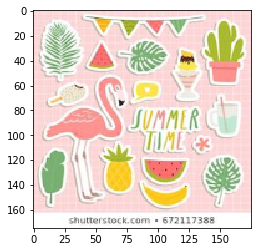

>> Train data..


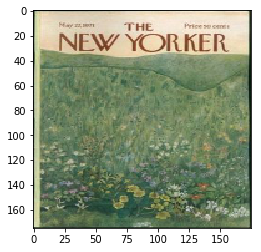

>> Test data..


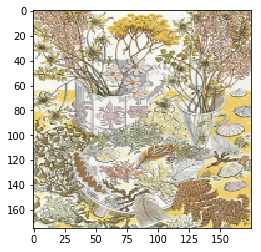

----------------
>> Test data..


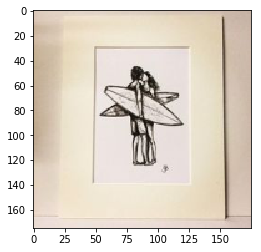

----------------


In [13]:
# 2.2 Visualising data
# --------------------

randrange = list(np.random.randint(x_ae_test.shape[0], size=(1, 2))[0,:])

for i in randrange:
    print('>> Train data..')
    plt.imshow(x_ae_train[i])
    plt.show()
    
for i in randrange:
    print('>> Test data..')
    plt.imshow(x_ae_test[i])
    plt.show()
    print('----------------')

In [14]:
# 2.3 Setting up training data for cmap pointwise fcn ae
# ------------------------------------------------------

x_train_ae_trn = Variable(setup_image_tensor(x_ae_train)).float()
x_test_ae_trn = Variable(setup_image_tensor(x_ae_test)).float()

ae_ht, ae_wd = x_train_ae_trn.size()[2], x_train_ae_trn.size()[3]

print(x_train_ae_trn.size())
print(x_test_ae_trn.size())

torch.Size([2598, 3, 175, 175])
torch.Size([250, 3, 175, 175])


#### 2.1.2 AE set up & training calls

In [29]:
# Using an FCN AE system
# ----------------------

model_ae = fcn_ae_3_layer()
model_ae.apply(weights_init)
model_ae

fcn_ae_3_layer(
  (convl1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (convl2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (convl3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): Softmax2d()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (upcl2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (upcl3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1

In [33]:
# trainig the model
# -----------------

''' USE -1 AS EPOCHS TO LOAD SAVED MODEL WITHOUT TRAINING '''

# model_train(xin,yin,xval,yval,load_mode,model,epochs,mbsize,loss_mode,flatten,use_cuda,save_state,path)

cn_file_name = 'ae_model_tboard_3_layer.tar'
cn_save_path = save_path + cn_file_name
print(cn_save_path)


model_ae = model_train(x_train_ae_trn[0:5],x_train_ae_trn[0:5],None,None,'from saved',model_ae,-1,5,'mse',False,use_cuda,True,cn_save_path)


/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/ae_model_tboard_3_layer.tar
Input and Output dataset normalised to 0-1
Loading model from saved state...
Last saved loss - 0.006657453719526529
Last saved epoch - 25


orig - 


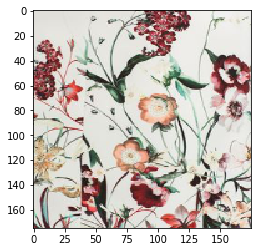

reconstructed - 


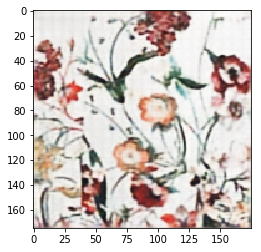

*************
orig - 


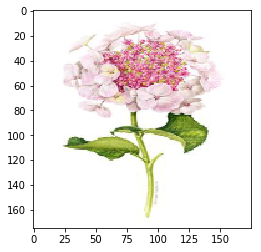

reconstructed - 


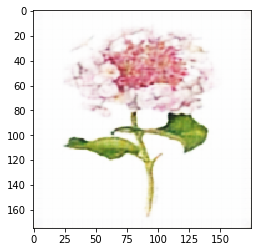

*************
orig - 


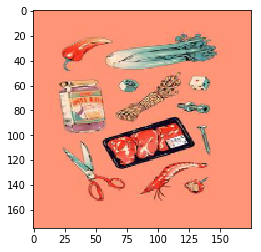

reconstructed - 


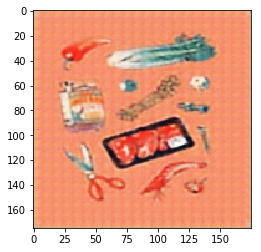

*************
orig - 


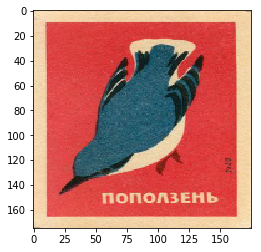

reconstructed - 


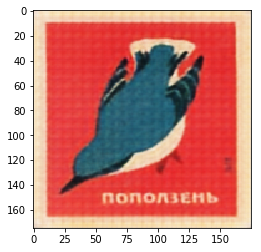

*************
orig - 


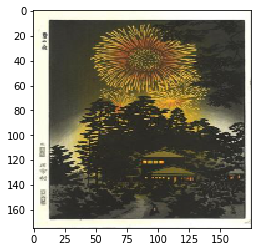

reconstructed - 


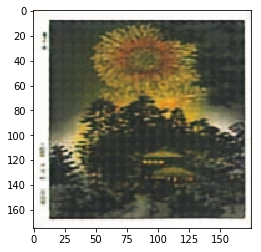

*************


In [38]:
# CHECKING RECONSTRUCTION
# -----------------------

no_reconstruction = 5
randrange = list(np.random.randint(x_ae_test.shape[0], size=(1, no_reconstruction))[0,:])

xtest_orig_sample = x_ae_test[randrange]
xtest_recons_sample = model_ae.eval()(Variable(setup_image_tensor(xtest_orig_sample/255)).float())
xtest_recons_sample = to_numpy_image(xtest_recons_sample)

# showing results
# ---------------
for i in range(xtest_orig_sample.shape[0]):
    print('orig - ')
    plt.imshow(xtest_orig_sample[i])
    plt.show()
    print('reconstructed - ')
    plt.imshow(xtest_recons_sample[i])
    plt.show()
    print('*************')
    

In [39]:
# END OF AE TRAINING

### 2.2 image search

(1063, 175, 175, 3)


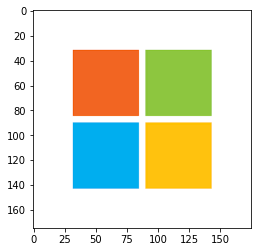

In [50]:
# loading searchable datast
# -------------------------

x_db = load_ext_dataset('/Users/venkateshmadhava/Desktop/si_test/',175,175)
print(x_db.shape)
plt.imshow(x_db[0])

(9, 175, 175, 3)


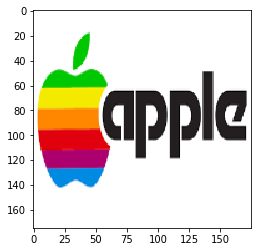

In [190]:
# loading input images dataset
# -----------------------------

x_input = load_ext_dataset('/Users/venkateshmadhava/Desktop/si_test_input/',175,175)
print(x_input.shape)
plt.imshow(x_input[0])


#### 2.2.1 getting latents

In [179]:
################# LATENT SETTINGS #################
###################################################


# setting ae latent pool mode
#############################

# what works -- max, deep, 9,2 and sim_mode = 'ratio'

ae_pool_mode = 'max' # avg and max and both
layer_mode = 'deep' # deep - for all 4 layers, non_deep for 3 layers
layer_dims_set = True
layer_f, layer_s = 9,2 #9,2 #9,2 #5,2 # 7,2 and both worked nice
model_ae.set_pool_mode(ae_pool_mode,layer_mode,layer_dims_set,layer_f,layer_s)

Modes set.


In [180]:
# getting latents - search db
# ---------------------------

latent_db = model_ae.eval().latent(Variable(setup_image_tensor(x_db/255)).float())
latent_db.size()

torch.Size([1063, 12544])

In [191]:
# getting latents - input
# -----------------------

latent_input = model_ae.eval().latent(Variable(setup_image_tensor(x_input/255)))
latent_input.size()

torch.Size([9, 12544])

#### 2.2.2 final results

>> At image 0 of around 9..
** Input Image - 


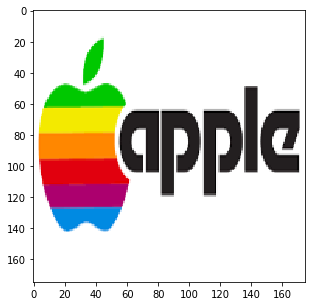

** Showing result images..
** At image 0 showing option number 0**
Image index number: 35
Similarity value: 1.0


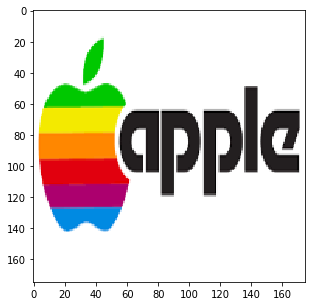

** At image 0 showing option number 1**
Image index number: 196
Similarity value: 0.63702893


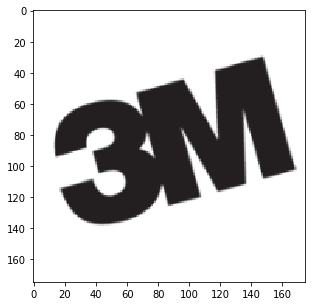

** At image 0 showing option number 2**
Image index number: 620
Similarity value: 0.63450724


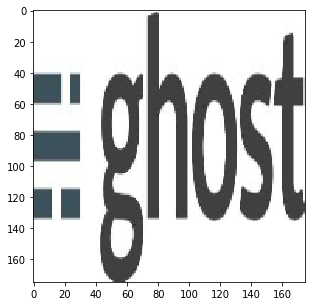

** At image 0 showing option number 3**
Image index number: 408
Similarity value: 0.6337801


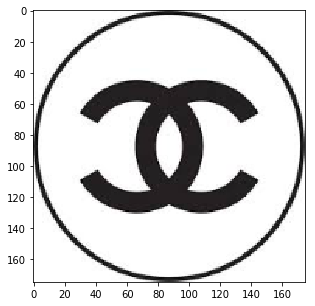

** At image 0 showing option number 4**
Image index number: 544
Similarity value: 0.6331334


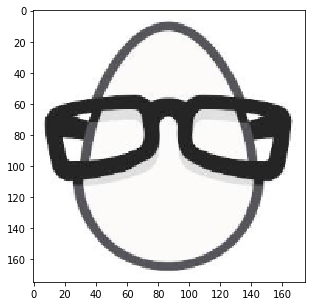


#########################################

>> At image 1 of around 9..
** Input Image - 


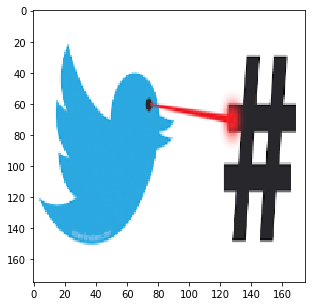

** Showing result images..
** At image 1 showing option number 0**
Image index number: 67
Similarity value: 1.0


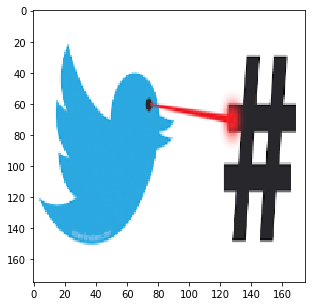

** At image 1 showing option number 1**
Image index number: 709
Similarity value: 0.61886525


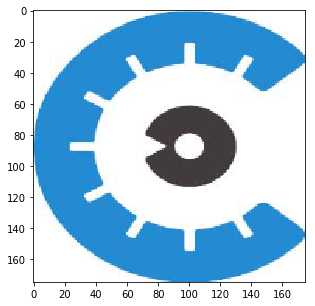

** At image 1 showing option number 2**
Image index number: 383
Similarity value: 0.61139286


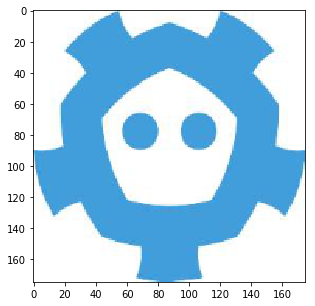

** At image 1 showing option number 3**
Image index number: 562
Similarity value: 0.61068857


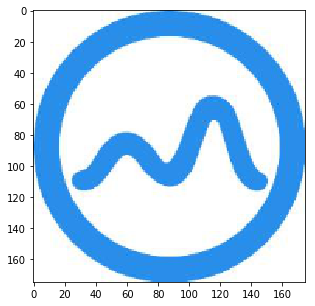

** At image 1 showing option number 4**
Image index number: 258
Similarity value: 0.6093515


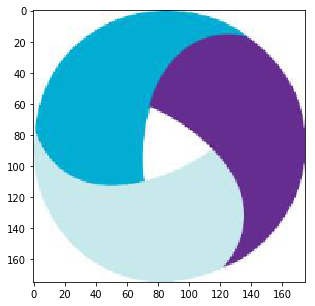


#########################################

>> At image 2 of around 9..
** Input Image - 


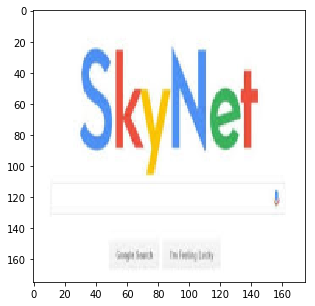

** Showing result images..
** At image 2 showing option number 0**
Image index number: 68
Similarity value: 1.0


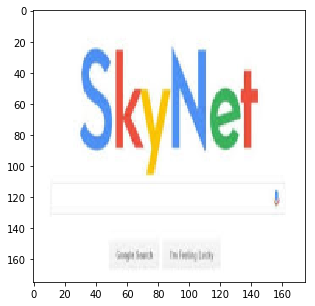

** At image 2 showing option number 1**
Image index number: 171
Similarity value: 0.6054706


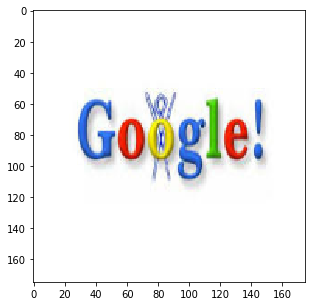

** At image 2 showing option number 2**
Image index number: 294
Similarity value: 0.6008284


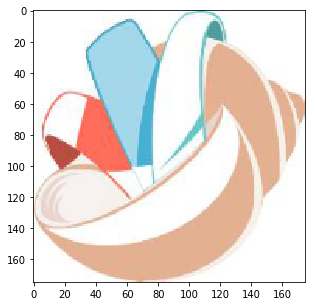

** At image 2 showing option number 3**
Image index number: 942
Similarity value: 0.59104115


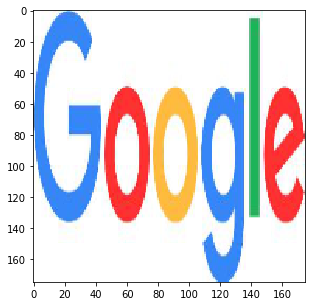

** At image 2 showing option number 4**
Image index number: 9
Similarity value: 0.59060746


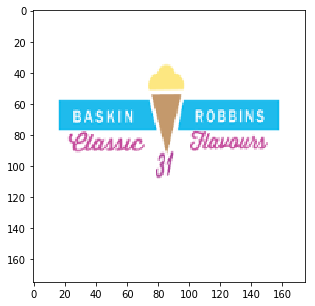


#########################################

>> At image 3 of around 9..
** Input Image - 


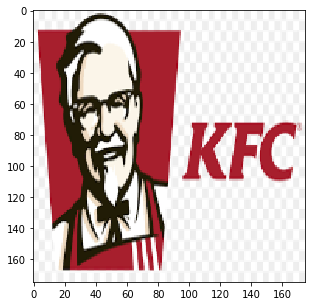

** Showing result images..
** At image 3 showing option number 0**
Image index number: 151
Similarity value: 1.0


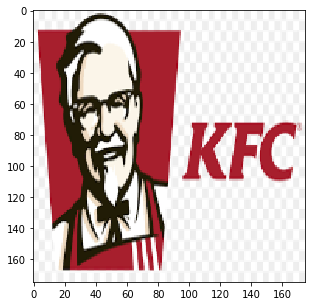

** At image 3 showing option number 1**
Image index number: 156
Similarity value: 0.61439264


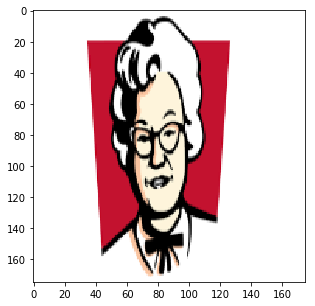

** At image 3 showing option number 2**
Image index number: 169
Similarity value: 0.61226416


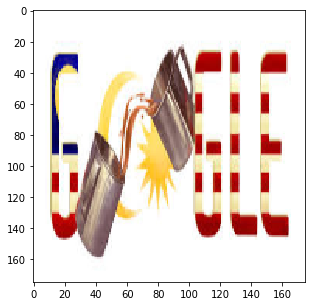

** At image 3 showing option number 3**
Image index number: 167
Similarity value: 0.60821164


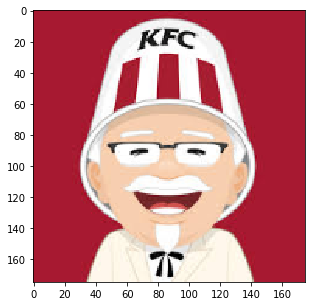

** At image 3 showing option number 4**
Image index number: 668
Similarity value: 0.6075459


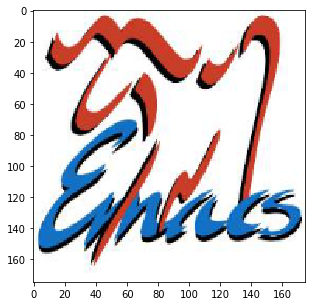


#########################################

>> At image 4 of around 9..
** Input Image - 


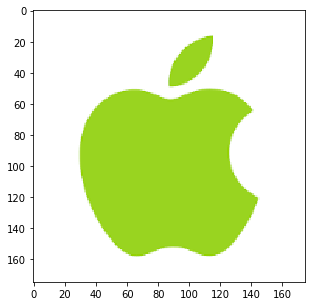

** Showing result images..
** At image 4 showing option number 0**
Image index number: 168
Similarity value: 1.0


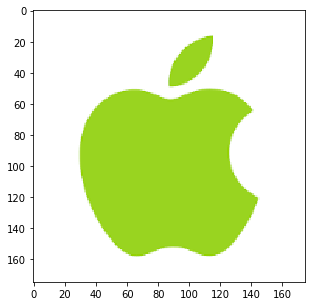

** At image 4 showing option number 1**
Image index number: 855
Similarity value: 0.6731798


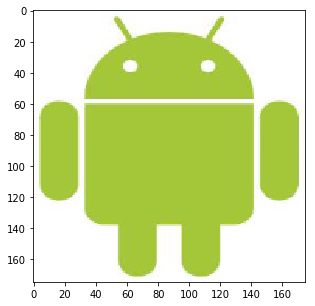

** At image 4 showing option number 2**
Image index number: 858
Similarity value: 0.5923073


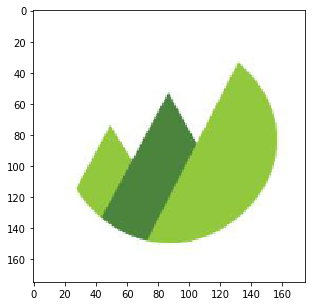

** At image 4 showing option number 3**
Image index number: 481
Similarity value: 0.57881945


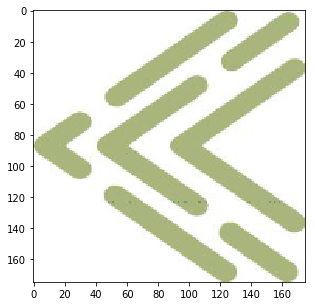

** At image 4 showing option number 4**
Image index number: 600
Similarity value: 0.5771522


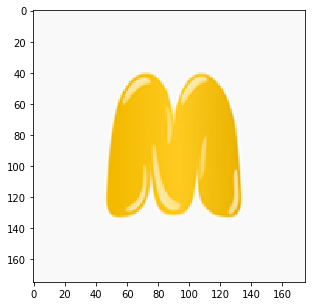


#########################################

>> At image 5 of around 9..
** Input Image - 


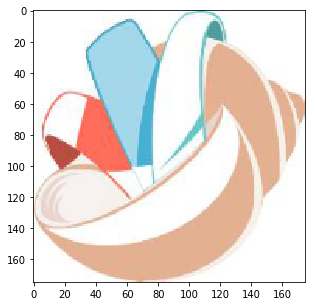

** Showing result images..
** At image 5 showing option number 0**
Image index number: 294
Similarity value: 1.0


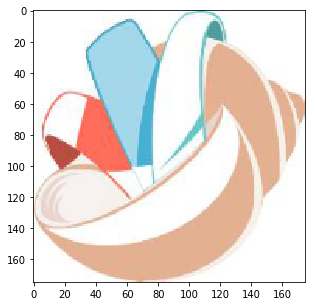

** At image 5 showing option number 1**
Image index number: 1002
Similarity value: 0.650216


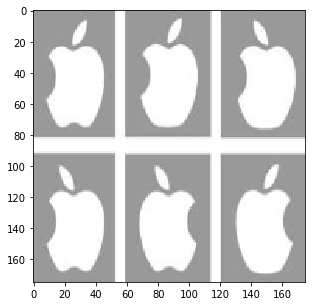

** At image 5 showing option number 2**
Image index number: 323
Similarity value: 0.6477409


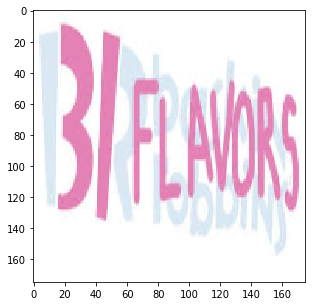

** At image 5 showing option number 3**
Image index number: 230
Similarity value: 0.6472633


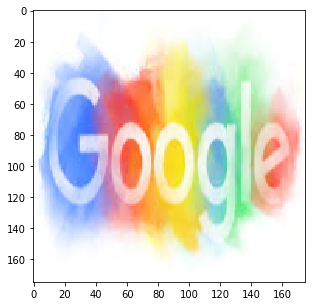

** At image 5 showing option number 4**
Image index number: 39
Similarity value: 0.64314497


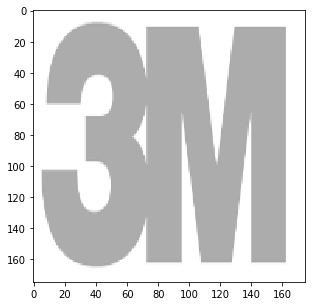


#########################################

>> At image 6 of around 9..
** Input Image - 


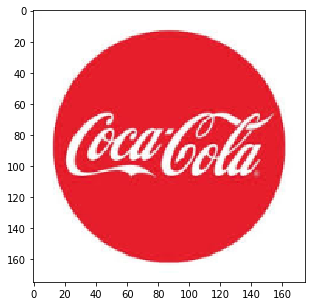

** Showing result images..
** At image 6 showing option number 0**
Image index number: 347
Similarity value: 1.0


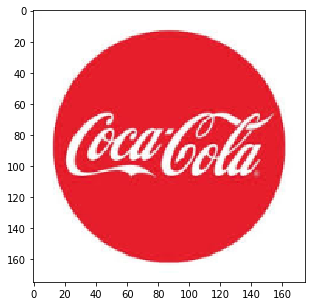

** At image 6 showing option number 1**
Image index number: 580
Similarity value: 0.6549253


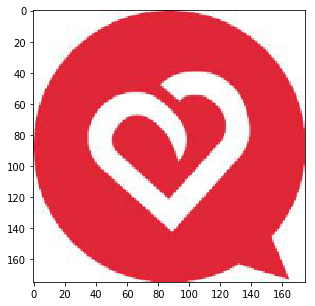

** At image 6 showing option number 2**
Image index number: 839
Similarity value: 0.6547014


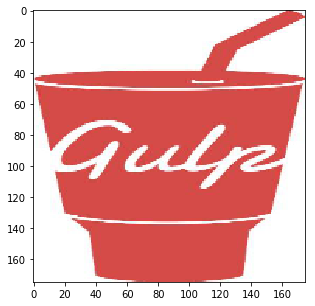

** At image 6 showing option number 3**
Image index number: 386
Similarity value: 0.65058184


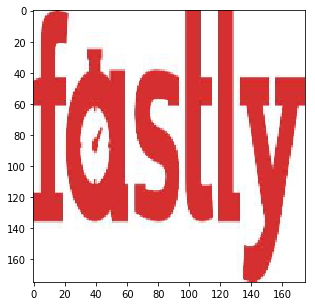

** At image 6 showing option number 4**
Image index number: 246
Similarity value: 0.649482


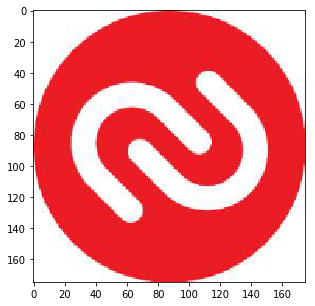


#########################################

>> At image 7 of around 9..
** Input Image - 


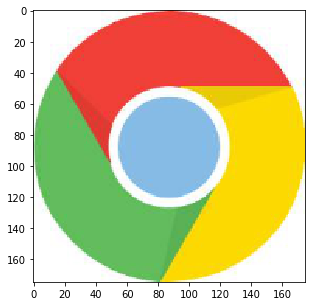

** Showing result images..
** At image 7 showing option number 0**
Image index number: 700
Similarity value: 1.0


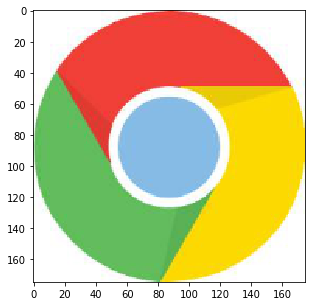

** At image 7 showing option number 1**
Image index number: 230
Similarity value: 0.6324029


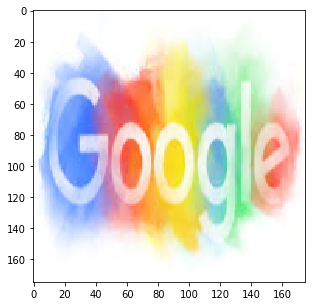

** At image 7 showing option number 2**
Image index number: 491
Similarity value: 0.6281288


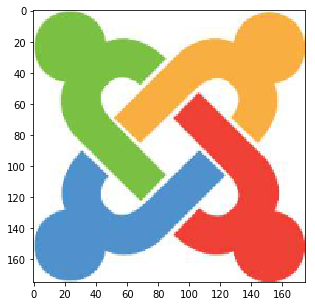

** At image 7 showing option number 3**
Image index number: 753
Similarity value: 0.6243874


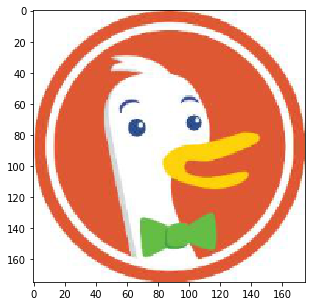

** At image 7 showing option number 4**
Image index number: 796
Similarity value: 0.6225815


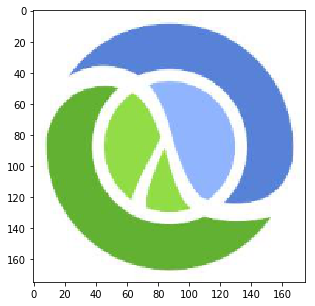


#########################################

>> At image 8 of around 9..
** Input Image - 


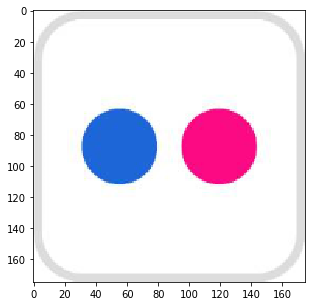

** Showing result images..
** At image 8 showing option number 0**
Image index number: 825
Similarity value: 1.0


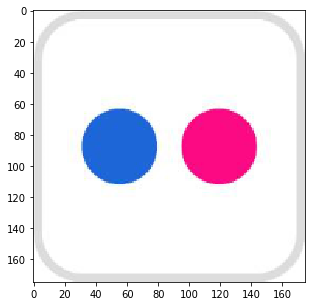

** At image 8 showing option number 1**
Image index number: 553
Similarity value: 0.63567805


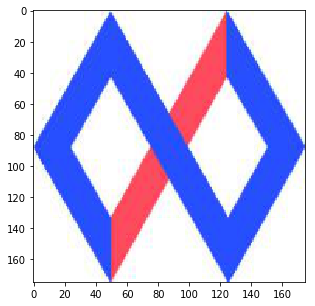

** At image 8 showing option number 2**
Image index number: 851
Similarity value: 0.6315286


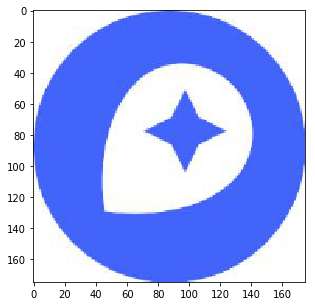

** At image 8 showing option number 3**
Image index number: 680
Similarity value: 0.6228934


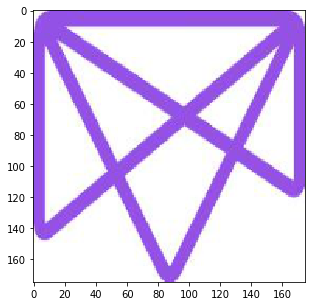

** At image 8 showing option number 4**
Image index number: 1033
Similarity value: 0.61641556


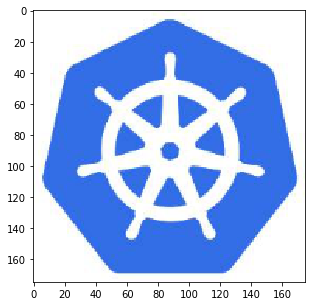


#########################################



In [192]:
# return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,similarity_check_threshold_value,single_input,print_result)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------


l,_,_ = return_similar_images(x_input,latent_input.data.numpy(),x_db,latent_db.data.numpy(),5,'ratio',0.5,False,True)
